In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

target = "./data/mnist/mnist.pkl.gz"
    

 




In [3]:
import pickle
import gzip

with gzip.open((target), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (28 times 28). Let's take a look at one; we need to reshpae it to 2d first

(50000, 784)


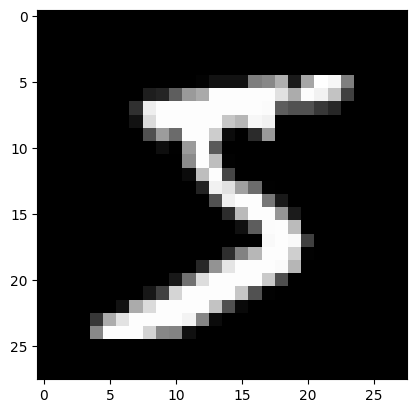

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Converting to torch.tensor

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
            torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

Note: for the weights, we set requires_grad __after__ the initialization, since we don't want that step included in the gradient. (Note that a trailing _ in PyTorch signifies that the operation is perfomed in-place.)

We are initializing the weights here with __Xavier initialisation__.

In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
print(bias)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [14]:
def log_softmax(x): # activation function
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb): # forward pass
    return log_softmax(xb @ weights + bias)

In [15]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.7301, -2.8468, -2.1045, -2.4153, -2.8323, -1.8947, -1.7846, -2.4119,
        -2.4921, -2.1540], grad_fn=<SelectBackward0>) torch.Size([64, 10])


the __preds__ tensor contains not only the tensor values, but also a gradient function. We will use this later to do backpropagation.

Not let us implement __negative log-likelihood__ to use as the loss function.

In [18]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()


# now defining the loss function

loss_func = nll

Checking the loss function, so we can see if we improve after a backprop pass later.

In [19]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3802, grad_fn=<NegBackward0>)


 Implementing a function to calculate the accurary of our model. For each prediction, if the index with the largerst value matches the target value, then the prediction was correct.

In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.0781)


We can now run a training loop. For each iteration, we will:

* select a mini-batch of data (of size bs)

* use the model to make predictions

* calculate the loss

* __loss.backward()__ updates the gradients of the model, in this case, __weights__ and __bias__.

Afterwards we will use torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient.
We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a runnig tally of all the operations that had happened.

You can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment set_trace() below to try it out.

In [32]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 20  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [28]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0817, grad_fn=<NegBackward0>) tensor(1.)


In [30]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0585, grad_fn=<NegBackward0>) tensor(1.)


In [31]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0585, grad_fn=<NegBackward0>) tensor(1.)


In [33]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0496, grad_fn=<NegBackward0>) tensor(1.)


It is actually getting better.

# Now let's refactor our code!!

`The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from torch.nn.functional (which is generally imported into the namespace F by convention). This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

In [34]:
# F.Cross_entropy combines: log likelihood and log softmax activation

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

because we have overwrittent the model function aka the forward step, we will check that the loss function and the accuracy are still the same from the last implement.

In [35]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0496, grad_fn=<NllLossBackward0>) tensor(1.)


## Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

In [36]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [37]:
model = Mnist_Logistic()

In [38]:
print(loss_func(model(xb), yb))

tensor(2.4657, grad_fn=<NllLossBackward0>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:


- with torch.no_grad(): 
   - weights -= weights.grad * lr
   - bias -= bias.grad * lr
   - weights.grad.zero_()
   - bias.grad.zero_()


Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

- with torch.no_grad():
    - for p in model.parameters(): p -= p.grad * lr
    - model.zero_grad()

We’ll wrap our little training loop in a _fit_ function so we can run it again later.

In [39]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:

In [40]:
print(loss_func(model(xb), yb))

tensor(0.0508, grad_fn=<NllLossBackward0>)


## Refactor using nn.Linear
We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.


In [41]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [42]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3411, grad_fn=<NllLossBackward0>)


In [43]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0511, grad_fn=<NllLossBackward0>)


## Refactor using optim

Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

- with torch.no_grad():
    - for p in model.parameters(): p -= p.grad * lr
    - model.zero_grad()

and instead use just:

- opt.step()
- opt.zero_grad()

(optim.zero_grad() resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)


In [45]:
from torch import optim


# we will define a little function to create our model and optmizer so we can 
# use in the future

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2967, grad_fn=<NllLossBackward0>)
tensor(0.0508, grad_fn=<NllLossBackward0>)


## Refactor using Dataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it.

In [47]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
- xb = x_train[start_i:end_i]
- yb = y_train[start_i:end_i]

Now, we can do these two steps together: 
xb,yb = train_ds[i*bs : i*bs+bs]

In [48]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0510, grad_fn=<NllLossBackward0>)


## Refactor using DataLoader

Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.


In [49]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this;

- for i in range((n-1)//bs + 1):
    - xb,yb = train_ds[i*bs : i*bs+bs]
    - pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader: 

- for xb,yb in train_dl:
    - pred = model(xb)

In [50]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0512, grad_fn=<NllLossBackward0>)
